In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install --upgrade -q kaggle

!mkdir /root/.kaggle
import json
token = {
    "username": "zahidhussain909",
    "key": "39a06efd89d0f2a699143b8d3d62b216"
}

with open('/root/.kaggle/kaggle.json', 'w') as config_file:
    json.dump(token, config_file)
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d zahidhussain909/denoised-oct-balanced

100% 1.04G/1.05G [00:29<00:00, 43.2MB/s]
100% 1.05G/1.05G [00:29<00:00, 38.0MB/s]


In [3]:
import zipfile
zipref=zipfile.ZipFile("/content/denoised-oct-balanced.zip",'r')
zipref.extractall()
zipref.close()

!rm -rf /content/denoised-oct-balanced.zip

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
num_class=len(os.listdir("/content/DENOISED OCT/train"))
num_class

train_dir = "/content/DENOISED OCT/train"
test_dir = "/content/DENOISED OCT/train"


train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

train_set = train_datagen.flow_from_directory(train_dir,batch_size=32,
                                               class_mode='categorical',
                                               target_size=(180,180))

val_set = test_datagen.flow_from_directory(test_dir,batch_size=32,
                                               class_mode='categorical',
                                               target_size=(180,180))

Found 32060 images belonging to 4 classes.
Found 32060 images belonging to 4 classes.


In [5]:
num_classes = 4
input_shape = (180,180,3)

In [6]:
# Model
#IMAGE_SIZE = [224, 224]
IMAGE_SIZE=180
BATCH_SIZE = 32  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "CNV",
    "DME",
    "DRUSEN",
    "NORMAL"
]  # don't change the order

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

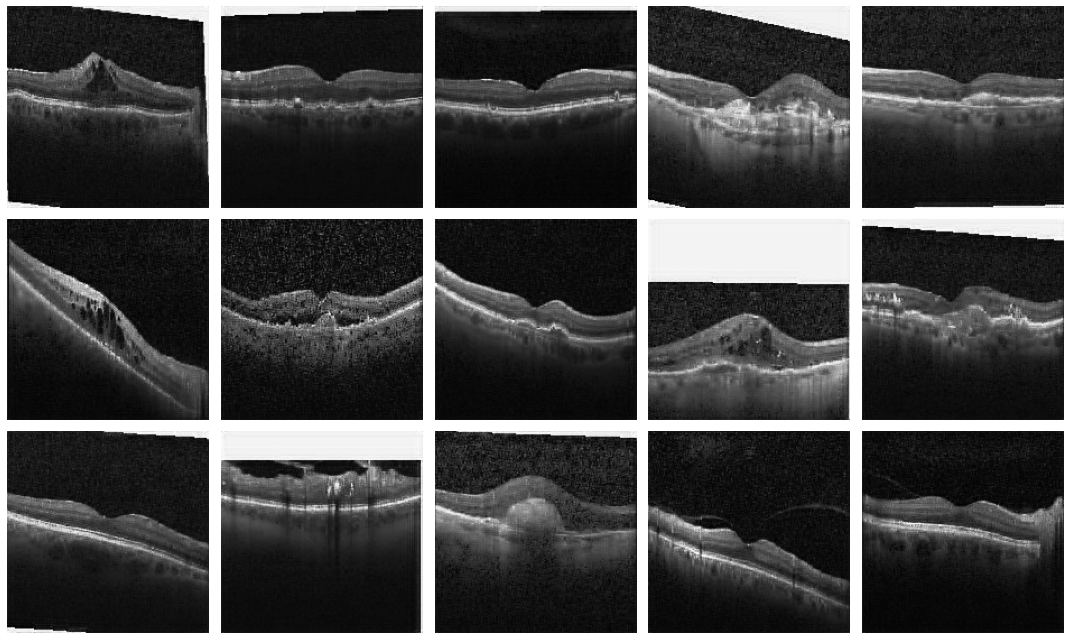

In [7]:
sample_images, sample_labels = next(iter(train_set))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n])
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    #plt.title(CLASSES[sample_labels[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
custom5 = tf.keras.Sequential([
                              tf.keras.layers.Conv2D(100,3,activation='relu',input_shape=(180,180,3)),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.MaxPool2D(pool_size=3,padding='valid'),
                              tf.keras.layers.Conv2D(70,3,activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.MaxPool2D(),
                              tf.keras.layers.Conv2D(50,3,activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.MaxPool2D(),
                              tf.keras.layers.Conv2D(20,3,activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.MaxPool2D(),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(4,activation='softmax')       
])

In [9]:
custom5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 100)     2800      
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 100)    400       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 70)        63070     
                                                                 
 batch_normalization_1 (Batc  (None, 57, 57, 70)       280       
 hNormalization)                                                 
                                                        

In [10]:
custom5.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.PrecisionAtRecall(0.5),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.SpecificityAtSensitivity(0.5),'accuracy'])

history_5=custom5.fit(train_set,epochs=50,steps_per_epoch=len(train_set),validation_data=val_set,validation_steps=len(val_set),
                    callbacks = [tf.keras.callbacks.ModelCheckpoint("classify_model4.h5", monitor='accuracy', save_best_only=True, verbose = 1)])

Epoch 1/50
1002/1002 [==============================] - ETA: 0s - loss: 1.0843 - auc: 0.8226 - precision: 0.6296 - recall: 0.5164 - precision_at_recall: 0.6373 - true_negatives: 86441.0000 - false_positives: 9739.0000 - specificity_at_sensitivity: 0.9047 - accuracy: 0.5832
Epoch 1: accuracy improved from -inf to 0.58316, saving model to classify_model4.h5
1002/1002 [==============================] - 161s 149ms/step - loss: 1.0843 - auc: 0.8226 - precision: 0.6296 - recall: 0.5164 - precision_at_recall: 0.6373 - true_negatives: 86441.0000 - false_positives: 9739.0000 - specificity_at_sensitivity: 0.9047 - accuracy: 0.5832 - val_loss: 0.8064 - val_auc: 0.8981 - val_precision: 0.7081 - val_recall: 0.6448 - val_precision_at_recall: 0.7825 - val_true_negatives: 87658.0000 - val_false_positives: 8522.0000 - val_specificity_at_sensitivity: 0.9535 - val_accuracy: 0.6818
Epoch 2/50
1002/1002 [==============================] - ETA: 0s - loss: 0.5097 - auc: 0.9539 - precision: 0.8317 - recall: 0.